In [10]:
import sys

sys.path.append("..")

In [11]:
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
from model.long import LongConfig, LongForCausalLM
from transformers import GPT2Config, GPT2LMHeadModel
# from mamba_ssm import MambaLMHeadModel
from transformers import MambaConfig, MambaForCausalLM

import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm 
import numpy as np
import torch.nn.utils.rnn as rnn_utils
import matplotlib.pyplot as plt
import gc
import math
import os 
import random

In [12]:
# --- 1. REPRODUCIBILITY SETUP ---
def set_seed(seed=42):
    """
    Sets the seed for reproducibility across all libraries.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # Ensure deterministic behavior for CUDA (slightly slower but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"🌱 Seed set to {seed}")

In [13]:
class NeedleHaystackDataset(Dataset):
    def __init__(self, size=2000, min_len=32, max_len=64, vocab_size=128, depth=None):
        """
        depth: Float between 0.0 and 1.0. 
               If None, depth is randomized for every sample (0% to 100%).
               If set (e.g., 0.5), the needle is always placed at 50% context.
        """
        self.size = size
        self.min_len = min_len
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.depth = depth
        
        # We reserve the last token as the specific "Prompt" trigger
        self.prompt_token = torch.tensor([vocab_size - 1]) 
        
    def __len__(self): 
        return self.size

    def __getitem__(self, idx):
        # 1. Determine total length of the sequence
        curr_len = np.random.randint(self.min_len, self.max_len + 1)
        
        # 2. Generate the Key (Needle)
        # Range: [1, vocab-2] to avoid padding (0) and prompt token (vocab-1)
        key = torch.randint(1, self.vocab_size - 1, (1,))
        
        # 3. Generate Noise (Haystack)
        # We need space for 2 prompt tokens and 2 key tokens (4 tokens total overhead)
        noise_len = max(0, curr_len - 4)
        noise = torch.randint(1, self.vocab_size - 1, (noise_len,))
        
        # 4. Determine Insertion Point (Depth)
        if self.depth is not None:
            # Fixed depth (e.g., 0.9 for 90% deep)
            insert_idx = int(noise_len * self.depth)
        else:
            # Fully Random depth (0% to 100%)
            # FIX: Previously this was noise_len // 2 (biased to start)
            insert_idx = torch.randint(0, noise_len + 1, (1,)).item()
        
        # 5. Construct Sequence
        # [Noise Part A] -> [Prompt] -> [Key] -> [Noise Part B] -> [Prompt] -> [Key (Target)]
        input_ids = torch.cat([
            noise[:insert_idx], 
            self.prompt_token, key,      
            noise[insert_idx:], 
            self.prompt_token, key       
        ])
        
        # 6. Create Labels (Mask everything except the final Key)
        labels = input_ids.clone()
        # Mask everything up to the final token
        labels[:-1] = -100 
        
        return {"input_ids": input_ids, "labels": labels}

In [14]:
def pad_collate_fn(batch):
    inputs = rnn_utils.pad_sequence([x['input_ids'] for x in batch], batch_first=True, padding_value=0)
    labels = rnn_utils.pad_sequence([x['labels'] for x in batch], batch_first=True, padding_value=-100)
    return {"input_ids": inputs, "labels": labels}


🌱 Seed set to 42
LongForCausalLM(
  (long_model): LongModel(
    (wte): Embedding(1000, 64)
    (layers): ModuleList(
      (0-1): 2 x LongBlock(
        (attn): LongAttention(
          (q_proj): Linear(in_features=64, out_features=64, bias=False)
          (k_proj): Linear(in_features=64, out_features=64, bias=False)
          (v_proj): Linear(in_features=64, out_features=64, bias=False)
          (conv): Conv1d(64, 64, kernel_size=(4,), stride=(1,), padding=(3,), groups=64)
          (input_gate_proj): Linear(in_features=64, out_features=64, bias=True)
          (output_gate_proj): Linear(in_features=64, out_features=64, bias=True)
          (gamma_proj): Linear(in_features=64, out_features=4, bias=True)
          (o_proj): Linear(in_features=64, out_features=64, bias=False)
          (v_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (grp_norm): GroupNorm(4, 64, eps=1e-05, affine=True)
          (mem_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)


Evaluating Long-LLM (HF):   0%|          | 0/11 [00:00<?, ?it/s]

L=64:   0%|          | 0/2 [00:00<?, ?it/s]

Length 64: Acc 100.00%


L=128:   0%|          | 0/2 [00:00<?, ?it/s]

Length 128: Acc 100.00%


L=256:   0%|          | 0/2 [00:00<?, ?it/s]

Length 256: Acc 100.00%


L=512:   0%|          | 0/2 [00:00<?, ?it/s]

Length 512: Acc 100.00%


L=1024:   0%|          | 0/2 [00:00<?, ?it/s]

Length 1024: Acc 97.00%


L=2048:   0%|          | 0/13 [00:00<?, ?it/s]

Length 2048: Acc 79.00%


L=4096:   0%|          | 0/13 [00:00<?, ?it/s]

Length 4096: Acc 12.00%


L=8192:   0%|          | 0/13 [00:00<?, ?it/s]

Length 8192: Acc 0.00%


L=16384:   0%|          | 0/50 [00:00<?, ?it/s]

Length 16384: Acc 1.00%


L=32768:   0%|          | 0/50 [00:00<?, ?it/s]

Length 32768: Acc 0.00%


L=65536:   0%|          | 0/50 [00:00<?, ?it/s]

Length 65536: Acc 0.00%

🚀 Training Mamba (HF)...
   Ep 5: Loss 6.7687
   Ep 10: Loss 0.0414
   Ep 15: Loss 0.0114
   Ep 20: Loss 0.0053
   Ep 25: Loss 0.0029
   Ep 30: Loss 0.0017
   🧪 Benchmarking Mamba (HF)...


Evaluating Mamba (HF):   0%|          | 0/11 [00:00<?, ?it/s]

L=64:   0%|          | 0/2 [00:00<?, ?it/s]

Length 64: Acc 100.00%


L=128:   0%|          | 0/2 [00:00<?, ?it/s]

Length 128: Acc 100.00%


L=256:   0%|          | 0/2 [00:00<?, ?it/s]

Length 256: Acc 100.00%


L=512:   0%|          | 0/2 [00:00<?, ?it/s]

Length 512: Acc 100.00%


L=1024:   0%|          | 0/2 [00:00<?, ?it/s]

Length 1024: Acc 100.00%


L=2048:   0%|          | 0/13 [00:00<?, ?it/s]

Length 2048: Acc 82.00%


L=4096:   0%|          | 0/13 [00:00<?, ?it/s]

Length 4096: Acc 28.00%


L=8192:   0%|          | 0/13 [00:00<?, ?it/s]

Length 8192: Acc 3.00%


L=16384:   0%|          | 0/50 [00:00<?, ?it/s]

Length 16384: Acc 0.00%


L=32768:   0%|          | 0/50 [00:00<?, ?it/s]

Length 32768: Acc 0.00%


L=65536:   0%|          | 0/50 [00:00<?, ?it/s]

Length 65536: Acc 0.00%

📊 Generating Figure...


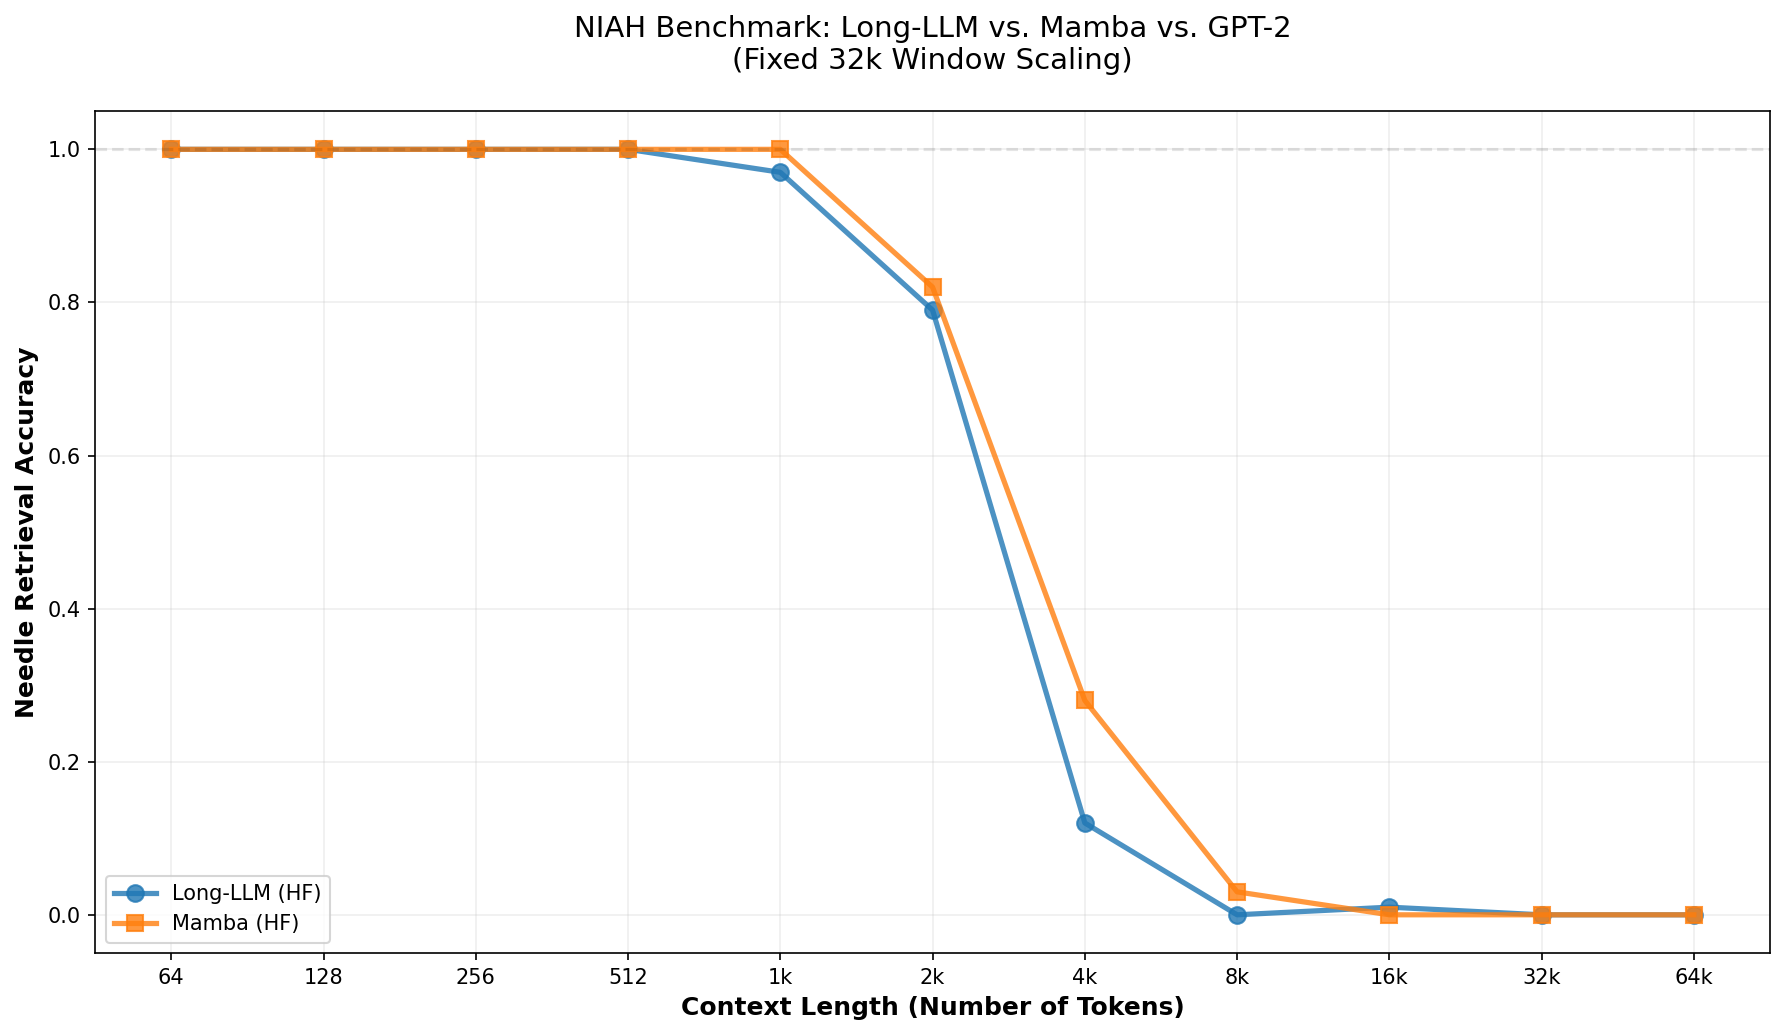

✅ Visualization saved as 'niah_results_2.png'.


In [15]:
from tqdm.auto import tqdm

def run_benchmark():
    set_seed(42)
    
    VOCAB_SIZE = 1000
    DIM = 64
    LAYERS = 2
    HEADS = 4
    EPOCHS = 30
    BATCH_SIZE = 64
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    
    # --- 1. Model Setup (Hugging Face Style) ---
    
    # Setup Long-LLM Config
    # Assuming LongConfig is your custom config class
    long_config = LongConfig(
        vocab_size = VOCAB_SIZE, 
        hidden_size = DIM, 
        num_hidden_layers = LAYERS, 
        num_heads = HEADS,
        expansion_ratio = 4, 
        hybrid_ratio = 0,
        gate_init_bias = -3,
        # This dim to support long context distances
        rope_base_dim = 1000000,
    )
    long_llm = LongForCausalLM(long_config).to(DEVICE)
    print(long_llm)
    # long_llm = LongNet(VOCAB_SIZE, DIM, LAYERS, HEADS).to(DEVICE)

    # Setup Mamba HF
    config_kwargs = {
         "vocab_size": VOCAB_SIZE, 
         "ssm_cfg": {"dropout": 0.0 }
    }
    mamba_config = MambaConfig(
        hidden_size = DIM,
        num_hidden_layers = LAYERS, 
        **config_kwargs
    )
    mamba_model = MambaForCausalLM(mamba_config).to(DEVICE)
    print(mamba_model)

    models = {
        "Long-LLM (HF)": long_llm,
        "Mamba (HF)": mamba_model,
    }
    
    # test_lengths = [64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144]
    test_lengths = [64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536] 

    results = {name: [] for name in models}
    
    for name, model in models.items():
        print(f"\n🚀 Training {name}...")

        lr = 0.001 if name == "Mamba (HF)" else 0.005
        # lr = 0.001
        
        opt = optim.AdamW(model.parameters(), lr=lr)
        train_ds = NeedleHaystackDataset(size=10000, min_len=32, max_len=128, vocab_size=VOCAB_SIZE)
        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=pad_collate_fn, shuffle=True)
        
        model.train()
        for ep in range(EPOCHS):
            loss_list = []
            for batch in train_loader:
                x, y = batch['input_ids'].to(DEVICE), batch['labels'].to(DEVICE)
                
                # --- HF-STYLE FORWARD ---
                # HF models can calculate loss internally if labels are passed
                outputs = model(input_ids=x, labels=y)
                
                if hasattr(outputs, 'loss') and outputs.loss is not None:
                    loss = outputs.loss
                else:
                    # Fallback for models that don't compute loss internally
                    logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                    shift_logits = logits[:, :-1, :].contiguous()
                    shift_labels = y[:, 1:].contiguous()
                    loss = F.cross_entropy(
                        shift_logits.view(-1, VOCAB_SIZE),
                        shift_labels.view(-1)
                    )
                
                opt.zero_grad()
                loss.backward()
                opt.step()
                loss_list.append(loss.item())
                
            if (ep+1) % 5 == 0:
                print(f"   Ep {ep+1}: Loss {np.mean(loss_list):.4f}")

        # --- 2. Benchmark Evaluation ---
        print(f"   🧪 Benchmarking {name}...")
        model.eval()
        
        # Outer progress bar for context lengths
        length_pbar = tqdm(test_lengths, desc=f"Evaluating {name}")
        for L in length_pbar:
            length_pbar.set_description(f"Eval {name} [Len: {L}]")
            gc.collect(); torch.cuda.empty_cache()
            
            eval_batch = 64 if L <= 1024 else (8 if L <= 8192 else 2)
            test_ds = NeedleHaystackDataset(size=100, min_len=L, max_len=L, vocab_size=VOCAB_SIZE, depth=0.5)
            test_loader = DataLoader(test_ds, batch_size=eval_batch, collate_fn=pad_collate_fn)
            
            hits, total = 0, 0
            try:
                with torch.no_grad():
                    # Inner progress bar for evaluation batches
                    for batch in tqdm(test_loader, desc=f"L={L}", leave=False):
                        x, y = batch['input_ids'].to(DEVICE), batch['labels'].to(DEVICE)
                        outputs = model(x)
                        logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                        
                        for i in range(x.size(0)):
                            valid = (y[i] != -100).nonzero(as_tuple=True)[0]
                            if len(valid) == 0: continue
                            target_pos = valid[-1].item()
                            pred = logits[i, target_pos-1].argmax().item()
                            if pred == y[i, target_pos].item(): hits += 1
                            total += 1
                            
                acc = hits / total if total > 0 else 0
                results[name].append(acc)
                print(f"Length {L}: Acc {acc * 100:.2f}%")
                # Update the outer bar with the current accuracy
                length_pbar.set_postfix(acc=f"{acc:.1%}")
                
            except RuntimeError as e:
                if "out of memory" in str(e).lower():
                    results[name].append(0.0)
                    length_pbar.set_postfix(status="OOM")
                else:
                    raise e
                    
    # --- 3. Visualization ---
    # (Same as your provided code, just use results dictionary)
    # ...
    print("\n📊 Generating Figure...")
    plt.figure(figsize=(12, 7), dpi=150)
    
    # Custom styling for professional look
    markers = {
        "Long-LLM (HF)": "o",  # Circle
        "Mamba (HF)": "s",     # Square
    }
    colors = {
        "Long-LLM (HF)": "#1f77b4", # Deep Blue
        "Mamba (HF)": "#ff7f0e",    # Bright Orange
    }

    for name, accs in results.items():
        # Plotting results
        plt.plot(
            test_lengths, 
            accs, 
            marker=markers.get(name, "d"), 
            color=colors.get(name, "#7f7f7f"), 
            linewidth=2.5, 
            markersize=8,
            label=name,
            alpha=0.8
        )
        
    # Formatting the X-axis for context lengths
    plt.xscale('log', base=2)
    x_labels = [str(l) if l < 1024 else f"{l//1024}k" for l in test_lengths]
    plt.xticks(test_lengths, x_labels)
    
    # Labels and Legend
    plt.xlabel("Context Length (Number of Tokens)", fontsize=12, fontweight='bold')
    plt.ylabel("Needle Retrieval Accuracy", fontsize=12, fontweight='bold')
    plt.title("NIAH Benchmark: Long-LLM vs. Mamba vs. GPT-2\n(Fixed 32k Window Scaling)", fontsize=14, pad=20)
    
    plt.ylim(-0.05, 1.05)
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend(frameon=True, loc='lower left', fontsize=10)
    
    # Adding a target line for 100% accuracy
    plt.axhline(y=1.0, color='black', linestyle='--', alpha=0.1)

    plt.tight_layout()
    plt.savefig("niah_results_2.png")
    plt.show()
    print("✅ Visualization saved as 'niah_results_2.png'.")

run_benchmark()

🔄 Starting Multi-Seed Benchmark on cuda
🌱 Seeds to run: [42, 1337, 2024]

🎬 STARTING RUN 1/3 (Seed: 42)
🌱 Seed set to 42

🚀 [Seed 42] Training Long-LLM...
   🧪 [Seed 42] Benchmarking Long-LLM...


Eval Long-LLM:   0%|          | 0/11 [00:00<?, ?it/s]


🚀 [Seed 42] Training Mamba...
   🧪 [Seed 42] Benchmarking Mamba...


Eval Mamba:   0%|          | 0/11 [00:00<?, ?it/s]


🎬 STARTING RUN 2/3 (Seed: 1337)
🌱 Seed set to 1337

🚀 [Seed 1337] Training Long-LLM...
   🧪 [Seed 1337] Benchmarking Long-LLM...


Eval Long-LLM:   0%|          | 0/11 [00:00<?, ?it/s]


🚀 [Seed 1337] Training Mamba...
   🧪 [Seed 1337] Benchmarking Mamba...


Eval Mamba:   0%|          | 0/11 [00:00<?, ?it/s]


🎬 STARTING RUN 3/3 (Seed: 2024)
🌱 Seed set to 2024

🚀 [Seed 2024] Training Long-LLM...
   🧪 [Seed 2024] Benchmarking Long-LLM...


Eval Long-LLM:   0%|          | 0/11 [00:00<?, ?it/s]


🚀 [Seed 2024] Training Mamba...
   🧪 [Seed 2024] Benchmarking Mamba...


Eval Mamba:   0%|          | 0/11 [00:00<?, ?it/s]


📊 Generating Aggregated Figure...


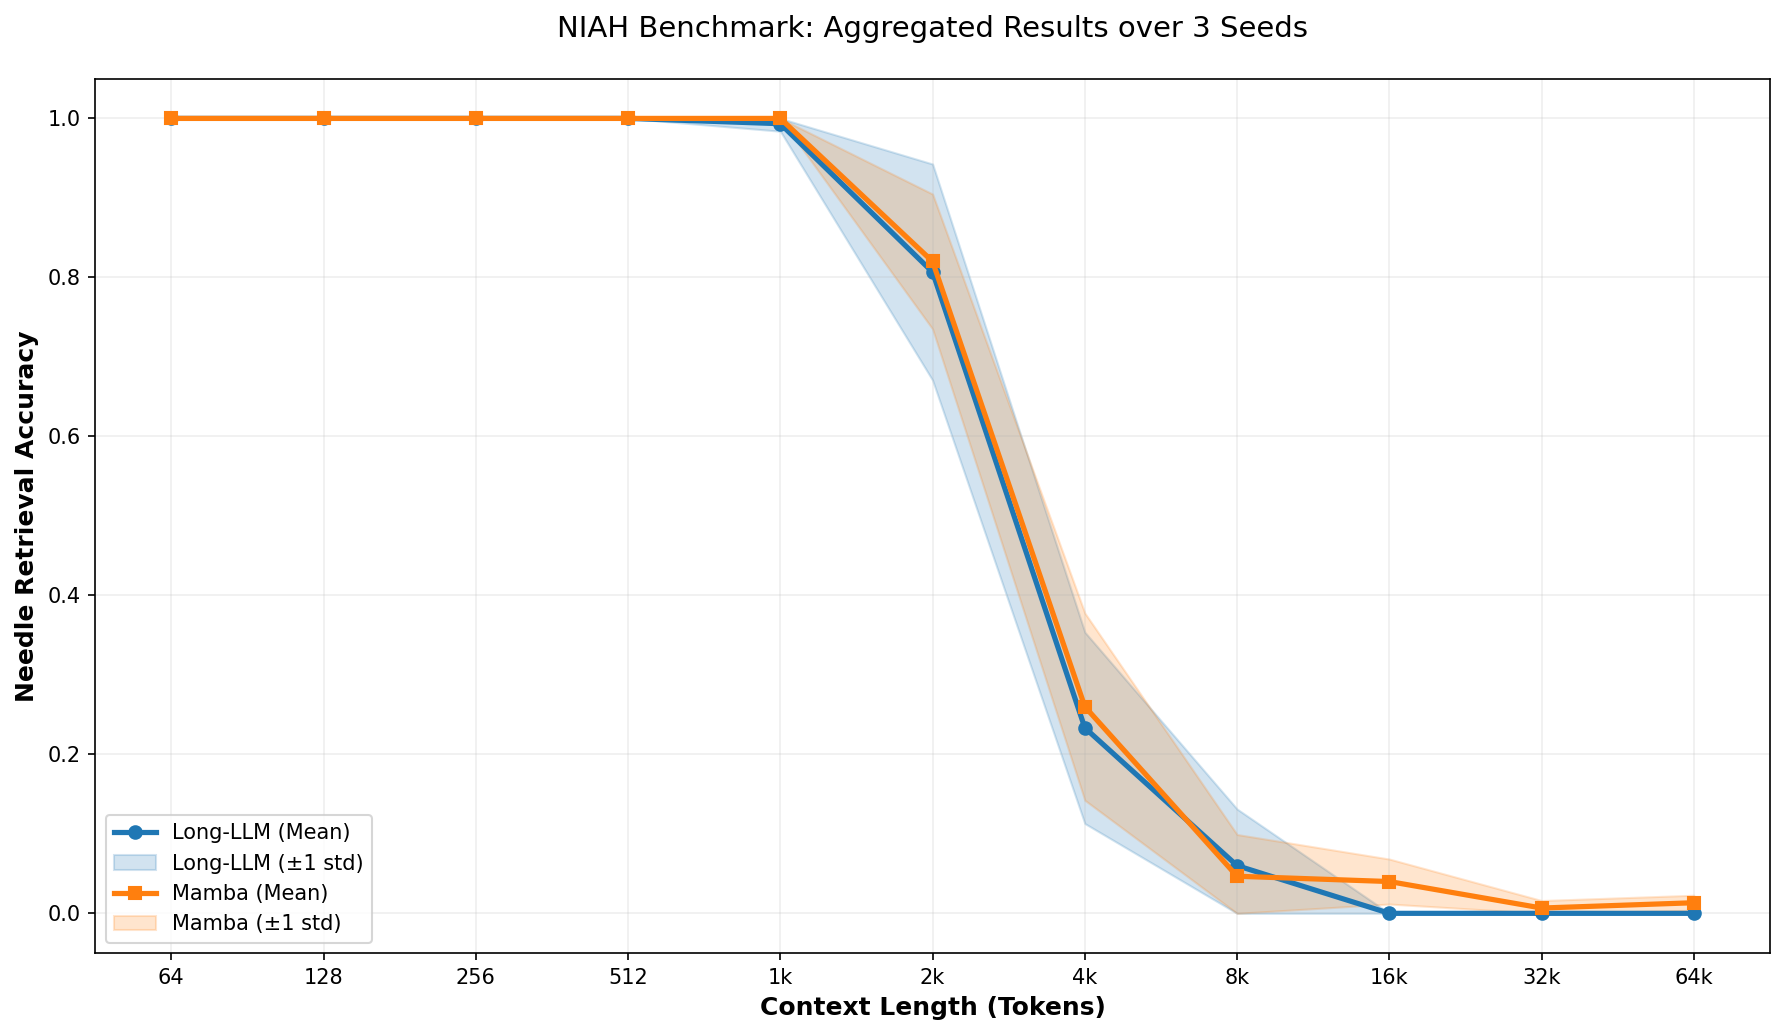

✅ Visualization saved.


In [16]:
def run_multi_seed_benchmark():
    # --- CONFIGURATION ---
    SEEDS = [42, 1337, 2024]  # We will run 3 times
    VOCAB_SIZE = 1000
    DIM = 64
    LAYERS = 2
    HEADS = 4
    EPOCHS = 30
    BATCH_SIZE = 64
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Context lengths to test
    test_lengths = [64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536] 
    
    # Store results: { "ModelName": { seed1: [acc, acc...], seed2: [acc, acc...] } }
    final_results = {} 

    print(f"🔄 Starting Multi-Seed Benchmark on {DEVICE}")
    print(f"🌱 Seeds to run: {SEEDS}")

    for seed_idx, seed in enumerate(SEEDS):
        print(f"\n{'='*40}")
        print(f"🎬 STARTING RUN {seed_idx+1}/{len(SEEDS)} (Seed: {seed})")
        print(f"{'='*40}")
        
        set_seed(seed)
        
        # --- Initialize Models (Fresh for every seed) ---
        long_config = LongConfig(
            vocab_size = VOCAB_SIZE, 
            hidden_size = DIM, 
            num_hidden_layers = LAYERS, 
            num_heads = HEADS,
            expansion_ratio = 4, 
            hybrid_ratio = 0,
            gate_init_bias = -3,
            rope_base_dim = 1000000,
        )
        long_llm = LongForCausalLM(long_config).to(DEVICE)
        
        mamba_config = MambaConfig(
            hidden_size = DIM,
            num_hidden_layers = LAYERS, 
            vocab_size=VOCAB_SIZE,
            ssm_cfg={"dropout": 0.0 }
        )
        mamba_model = MambaForCausalLM(mamba_config).to(DEVICE)

        models = {
            "Long-LLM": long_llm,
            "Mamba": mamba_model,
        }
        
        # Initialize storage for this seed if not exists
        for name in models:
            if name not in final_results: final_results[name] = {}
            final_results[name][seed] = []

        # --- Training Loop ---
        for name, model in models.items():
            print(f"\n🚀 [Seed {seed}] Training {name}...")
            lr = 0.001 if name == "Mamba" else 0.005
            opt = optim.AdamW(model.parameters(), lr=lr)
            
            # Re-create dataset so it uses the new seed's random state
            train_ds = NeedleHaystackDataset(size=10000, min_len=32, max_len=128, vocab_size=VOCAB_SIZE)
            train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=pad_collate_fn, shuffle=True)
            
            model.train()
            for ep in range(EPOCHS):
                for batch in train_loader:
                    x, y = batch['input_ids'].to(DEVICE), batch['labels'].to(DEVICE)
                    
                    outputs = model(input_ids=x, labels=y)
                    if hasattr(outputs, 'loss') and outputs.loss is not None:
                        loss = outputs.loss
                    else:
                        logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                        shift_logits = logits[:, :-1, :].contiguous()
                        shift_labels = y[:, 1:].contiguous()
                        loss = F.cross_entropy(shift_logits.view(-1, VOCAB_SIZE), shift_labels.view(-1))
                    
                    opt.zero_grad()
                    loss.backward()
                    opt.step()

            # --- Evaluation Loop ---
            print(f"   🧪 [Seed {seed}] Benchmarking {name}...")
            model.eval()
            
            length_pbar = tqdm(test_lengths, desc=f"Eval {name}", leave=False)
            for L in length_pbar:
                gc.collect(); torch.cuda.empty_cache()
                eval_batch = 64 if L <= 1024 else (8 if L <= 8192 else 2)
                
                test_ds = NeedleHaystackDataset(size=50, min_len=L, max_len=L, vocab_size=VOCAB_SIZE, depth=0.5)
                test_loader = DataLoader(test_ds, batch_size=eval_batch, collate_fn=pad_collate_fn)
                
                hits, total = 0, 0
                try:
                    with torch.no_grad():
                        for batch in test_loader:
                            x, y = batch['input_ids'].to(DEVICE), batch['labels'].to(DEVICE)
                            outputs = model(x)
                            logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                            
                            for i in range(x.size(0)):
                                valid = (y[i] != -100).nonzero(as_tuple=True)[0]
                                if len(valid) == 0: continue
                                target_pos = valid[-1].item()
                                pred = logits[i, target_pos-1].argmax().item()
                                if pred == y[i, target_pos].item(): hits += 1
                                total += 1
                                
                    acc = hits / total if total > 0 else 0
                    final_results[name][seed].append(acc)
                    length_pbar.set_postfix(acc=f"{acc:.1%}")
                    
                except RuntimeError as e:
                    if "out of memory" in str(e).lower():
                        final_results[name][seed].append(0.0)
                        length_pbar.set_postfix(status="OOM")
                    else:
                        raise e
        
        # Cleanup to free GPU memory for next seed
        del long_llm, mamba_model, opt, train_loader, test_loader
        gc.collect()
        torch.cuda.empty_cache()

    # --- 3. Visualization with Error Bars ---
    print("\n📊 Generating Aggregated Figure...")
    plt.figure(figsize=(12, 7), dpi=150)
    
    colors = {"Long-LLM": "#1f77b4", "Mamba": "#ff7f0e"}
    markers = {"Long-LLM": "o", "Mamba": "s"}

    for name, seed_data in final_results.items():
        # Convert dict {seed: [accs]} to matrix [seeds, lengths]
        data_matrix = np.array(list(seed_data.values()))
        
        # Calculate statistics
        mean_acc = np.mean(data_matrix, axis=0)
        std_acc = np.std(data_matrix, axis=0)
        
        # Plot Mean Line
        plt.plot(
            test_lengths, mean_acc, 
            label=f"{name} (Mean)", 
            color=colors[name], 
            marker=markers[name],
            linewidth=2.5
        )
        
        # Fill Variance (Mean ± Std Dev)
        plt.fill_between(
            test_lengths, 
            np.maximum(mean_acc - std_acc, 0), # Clip at 0
            np.minimum(mean_acc + std_acc, 1), # Clip at 1
            color=colors[name], 
            alpha=0.2,
            label=f"{name} (±1 std)"
        )

    plt.xscale('log', base=2)
    x_labels = [str(l) if l < 1024 else f"{l//1024}k" for l in test_lengths]
    plt.xticks(test_lengths, x_labels)
    plt.xlabel("Context Length (Tokens)", fontsize=12, fontweight='bold')
    plt.ylabel("Needle Retrieval Accuracy", fontsize=12, fontweight='bold')
    plt.title(f"NIAH Benchmark: Aggregated Results over {len(SEEDS)} Seeds", fontsize=14, pad=20)
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend(loc='lower left', fontsize=10)
    plt.tight_layout()
    plt.savefig("niah_multi_seed_results.png")
    plt.show()
    print("✅ Visualization saved.")

run_multi_seed_benchmark()